## Feature Selection with Mutual Information

The aim of this notebook:
- Look at column features and how they influence a cell's self-exciting property (mutual info)

In [1]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer, get_data_sub_paths, pshape, get_data_resolutions
from models.kangkang_fnn_models import KangFeedForwardNetwork, SimpleKangFNN
from dataloaders.flat_loader import FlatDataLoaders, MockLoader, MockLoaders
from datasets.flat_dataset import FlatDataGroup

from dataloaders.cell_loader import CellDataLoaders
from datasets.cell_dataset import CellDataGroup

from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, PerTimeStepPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics, save_metrics
from utils.mock_data import mock_fnn_data_classification
from utils.plots import im
from trainers.generic_trainer import train_model
from models.kangkang_fnn_models import train_epoch_for_fnn
from utils.configs import BaseConf
from utils.metrics import best_threshold, get_y_pred
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup

from utils.mock_data import mock_fnn_data_classification
import matplotlib.pyplot as plt
from utils.plots import im
from utils.metrics import best_threshold, get_y_pred, get_y_pred_by_thresholds, best_thresholds
from models.model_result import ModelResult, ModelMetrics, save_metrics, compare_all_models,\
                                get_models_metrics, get_models_results
from pprint import pprint
from time import time
from utils.setup import setup

from utils.preprocessing import Shaper
import plotly.graph_objects as go

# Why conditional mutual information is larger than mutual information
The conditional variable has more possible states and therfore the join has a higher entropy - the maximum value it can take on can therefore be higher - to make plots easier to read we can normalize the mutual information with the mutual information of the target signal with itself.

$I(X;Y) = H(X) + H(Y) - H(X,Y)$


$I(X;Y|Z) = H(X,Z) + H(Y,Z) - H(X,Y,Z) - H(Z)$

In [5]:
from sparse_discrete_table import SparseDiscreteTable, build_discrete_table
from ipywidgets import widgets
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import plotly.graph_objects as go

In [80]:
def plot(y, x, mode='lines+markers'):
#     x = np.arange(len(y))
        
    data = [go.Scatter(x=x,y=y,mode=mode)]
    layout = dict(width=900,height=400)
    return go.FigureWidget(data=data, layout=layout)

In [247]:
def run_trails(fn, fn_kwargs, ntrails):
    trails = []
    for n in range(ntrails):
        obs = fn(**fn_kwargs)
        mi = gen_mi(obs)
        trails.append(mi)
    return trails

### Tets mutual information on Hawkes Process Simulations

In [246]:
from tick.plot import plot_point_process
from tick.hawkes import SimuHawkes, HawkesKernelSumExp
from scipy.stats import poisson


def gen_hawkes(baseline, intensity, decay, run_time):
    hawkes = SimuHawkes(n_nodes=1, end_time=run_time, verbose=False, seed=np.random.randint(10**6))
    kernel = HawkesKernelSumExp(intensities=[.5], decays=[10], )
    hawkes.set_kernel(i=0, j=0, kernel=kernel)
    hawkes.set_baseline(i=0, baseline=.5)
    
    hawkes.simulate()
    timestamps = hawkes.timestamps
    
    hawkes_counts, _ = np.histogram(hawkes.timestamps,np.arange(0,run_time))
    return hawkes_counts

def gen_obs(k,mu,w,n):
    obs = []
    for i in range(n):
        lam = mu+k
        try:
            o = poisson.rvs(mu=lam,size=1)
            obs.append(o[0])
            k = k*(1-w) + o*(w)
        except ValueError as e:
            raise ValueError(f"{e} - lam={lam}")
            
    return obs


def gen_mi(obs, max_offset=30, norm=False):
    mis = []
    for t in range(1,max_offset):
        xy = np.stack([obs[t:], obs[:-t]], axis=1)
        dt = build_discrete_table(xy, ['x','y'])
        mi = dt.mutual_information(['x'], ['y'],norm)
    #     print(f"mi: {mi}")
        mis.append(mi)
    return mis

In [279]:
state = dict(
    baseline=0.5, 
    intensity=0.5, 
    decay=2, 
    run_time=1000,
)
    
y_hawkes = gen_hawkes(
    baseline=0.5, 
    intensity=0.5, 
    decay=2, 
    run_time=1000,
)
x_hawkes = np.arange(len(y_hawkes))
fig = plot(y=y_hawkes,x=x_hawkes) 

y_mi = gen_mi(y_hawkes, norm=True)
x_mi = np.arange(len(y_hawkes))    
fig_mi = plot(y=y_mi,x=x_mi) 
    
def hawkes_callback(change):
    global state, fig, fig_mi
    if isinstance(change, dict) and change['name'] == 'value':
        value = change['new']
        name = change['owner'].description
        state[name] = value
        
        y_hawkes = gen_hawkes(**state)
        x_hawkes = np.arange(len(y_hawkes))
        
        with fig.batch_update():
            fig.data[0].x = x_hawkes
            fig.data[0].y = y_hawkes
            
        y_mi = gen_mi(y_hawkes, max_offset=60, norm=True)
        x_mi = np.arange(len(y_mi))                        
        with fig_mi.batch_update():
            fig_mi.data[0].x = x_mi
            fig_mi.data[0].y = y_mi            

            
def new_sliders(state, callback_fn):
    sliders = []
    for k,v in state.items():        
        slider = widgets.FloatSlider(
            value=v,
            min=v,
            max=10*v,
            step=v,
            description=k,
            continuous_update=False,
        ) 
        slider.observe(callback_fn)
        sliders.append(slider)
    return sliders

sliders = new_sliders(state, hawkes_callback)

widgets.VBox([
    *sliders,
    fig_mi,
    fig,
])

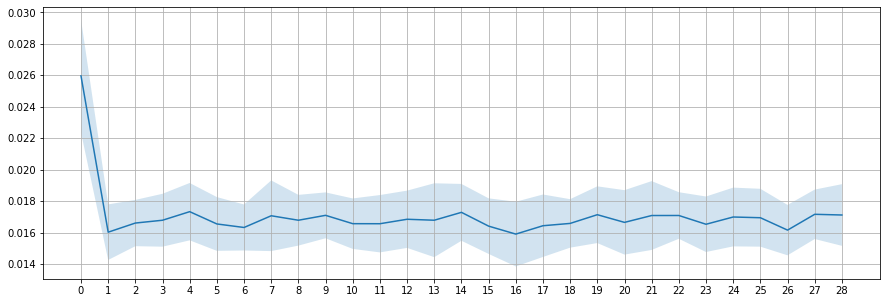

In [277]:
trails = run_trails(gen_hawkes, state, 20)
trails_mean = np.mean(trails,axis=0)
trails_std = np.std(trails,axis=0)
trails_x = np.arange(len(trails_mean))
plt.figure(figsize=(15,5))
plt.plot(trails_mean)
plt.fill_between(x=trails_x, y1=trails_mean-trails_std, y2=trails_mean+trails_std, alpha=0.2)
plt.grid()
plt.xticks(trails_x)
plt.show()

# Interactive Plotly Plots

In [15]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
from utils.data_processing import time_series_to_time_index
from pprint import pprint

In [16]:
pd.set_option('mode.chained_assignment', None)

In [17]:
mapbox_access_token = open(".mapbox_token").read()
# mapbox_access_token = "open-street-map"
mapbox_access_token

on_state = ('#f050ae', 8)
off_state = ('#ffab00', 8)

mapbox_styles = {
    "sat": "mapbox://styles/bernsblack/ckecz0wr52pfc1at7tvu43fmj", 
    "mono": "mapbox://styles/bernsblack/ckecyyizy065w19psrikmeo5d",
    "dark": "mapbox://styles/bernsblack/ckeikbchd254619s57np6iyum",
}

color_palette = ["#33a8c7","#52e3e1","#a0e426","#fdf148","#ffab00","#f77976","#f050ae","#d883ff","#9336fd"]

`Just for reference where Crimes_Chicago_2001_to_2019_datetime_fmt came from:`
```python
# was used to convert original csv to dataframe and string dates to datetime format
df = pd.read_csv("data/original/Crimes_Chicago_2001_to_2019.csv")
df['Date'] = pd.DatetimeIndex(pd.to_datetime(df['Date']))
df = df[[
    'ID',
    'Date',
    'Primary Type',
    'Arrest',
    'Latitude',
    'Longitude',
]].dropna()
df.to_pickle("data/raw/Crimes_Chicago_2001_to_2019_datetime_fmt.pkl") # Dates are type datetime not string
```

In [35]:
df = pd.read_pickle("data/raw/Crimes_Chicago_2001_to_2019_datetime_fmt.pkl")

In [36]:
# used to remove the anomalies
LAT_MAX = 42.0228
LON_MAX = -87.5244

LAT_MIN = 41.6445
LON_MIN = -87.9344

lon_limits = (df.Longitude > LON_MIN) & (df.Longitude < LON_MAX)
lat_limits = (df.Latitude > LAT_MIN) & (df.Latitude < LAT_MAX)
date_limits = (df.Date >= '2012-01-01') & (df.Date < '2017-01-01')

In [37]:
df = df[lon_limits & lat_limits & date_limits]

In [38]:
# filter out rare crime categories
# top_k_crimes_cats = len(color_palette)
# crime_categories = list(df['Primary Type'].value_counts().index)[:top_k_crimes_cats]
crime_categories = [
        "THEFT",
        "BATTERY",
        "CRIMINAL DAMAGE",
        "NARCOTICS",
        "ASSAULT",
        "BURGLARY",
        "MOTOR VEHICLE THEFT",
        "ROBBERY",
]

df = df[df['Primary Type'].isin(crime_categories)]

In [39]:
from pandas.api.types import CategoricalDtype
# Label encode the crime catgegories - makes histograms faster
CrimeType = CategoricalDtype(categories=crime_categories, ordered=True)
df['Primary Type'] = df['Primary Type'].astype(CrimeType)
df['c'] = df['Primary Type'].cat.codes

In [40]:
df['t'] = time_series_to_time_index(t_series=df.Date, t_step='1D', floor=True)
# df['t'] = time_series_to_time_index(t_series=df.Date, t_step='1H', floor=True)

In [41]:
from utils.utils import ffloor, fceil

In [42]:
from geopy import distance

# get meter per degree estimat
coord_series = df[['Latitude', 'Longitude']]

lat_min, lon_min = coord_series.min()
lat_max, lon_max = coord_series.max()

lat_mean, lon_mean = coord_series.mean()

dy = distance.distance((lat_min, lon_min), (lat_max, lon_min)).m
dx = distance.distance((lat_min, lon_min), (lat_min, lon_max)).m

lat_per_metre = (lat_max - lat_min)/dy
lon_per_metre = (lon_max - lon_min)/dx

ratio_xy = dx/dy
print(f"ratio_xy: {ratio_xy}")
print(f"lat_per_metre: {lat_per_metre}")
print(f"lon_per_metre: {lon_per_metre}")

ratio_xy: 0.8127895963778615
lat_per_metre: 9.003326781922841e-06
lon_per_metre: 1.2003344797182708e-05


### Very important  - all the meta data is mapped from intervals of 0.001 in the lat and lon space with ratios of 8 and 11 to ensure that the grids cels are square

#### Confirm the make_grid technique and hist product the same output

In [43]:
# [20,16] - [10,8] - [5,4] - [3,2] - [1,1]
x_scale, y_scale = 5,4#3,2
xy_scale = np.array([x_scale, y_scale])  # must be integer so that we can easily sample demographic data
dlon, dlat = xy_scale * np.array([0.001, 0.001])
meta_info = {}
meta_info["x_scale"] = x_scale
meta_info["y_scale"] = y_scale
meta_info["dlon"] = float(dlon)
meta_info["dlat"] = float(dlat)
meta_info["x in metres"] = 85000 * float(dlon)
meta_info["y in metres"] = 110000 * float(dlat)

pprint(meta_info)

# use perfect squares perfect squares
"""
all the meta data is mapped from intervals of 0.001 in 
the lat and lon space with ratios of 8 and 11 to ensure that the grids cels are square
"""
# cell_size_m = 430
# dlat = cell_size_m*lat_per_metre
# dlon = cell_size_m*lon_per_metre
 
# use increments of 0.001

xbins = np.arange(ffloor(lon_min, dlon),fceil(lon_max,dlon), dlon)
nx = len(xbins)

ybins = np.arange(ffloor(lat_min, dlat),fceil(lat_max,dlat), dlat)
ny = len(ybins)

nt = int(np.ceil(df['t'].max()))
tbins = np.arange(int(np.floor(df['t'].min())),nt+2,1)

nc = len(crime_categories)
cbins = np.arange(0,nc+1,1)

{'dlat': 0.004,
 'dlon': 0.005,
 'x in metres': 425.0,
 'x_scale': 5,
 'y in metres': 440.0,
 'y_scale': 4}


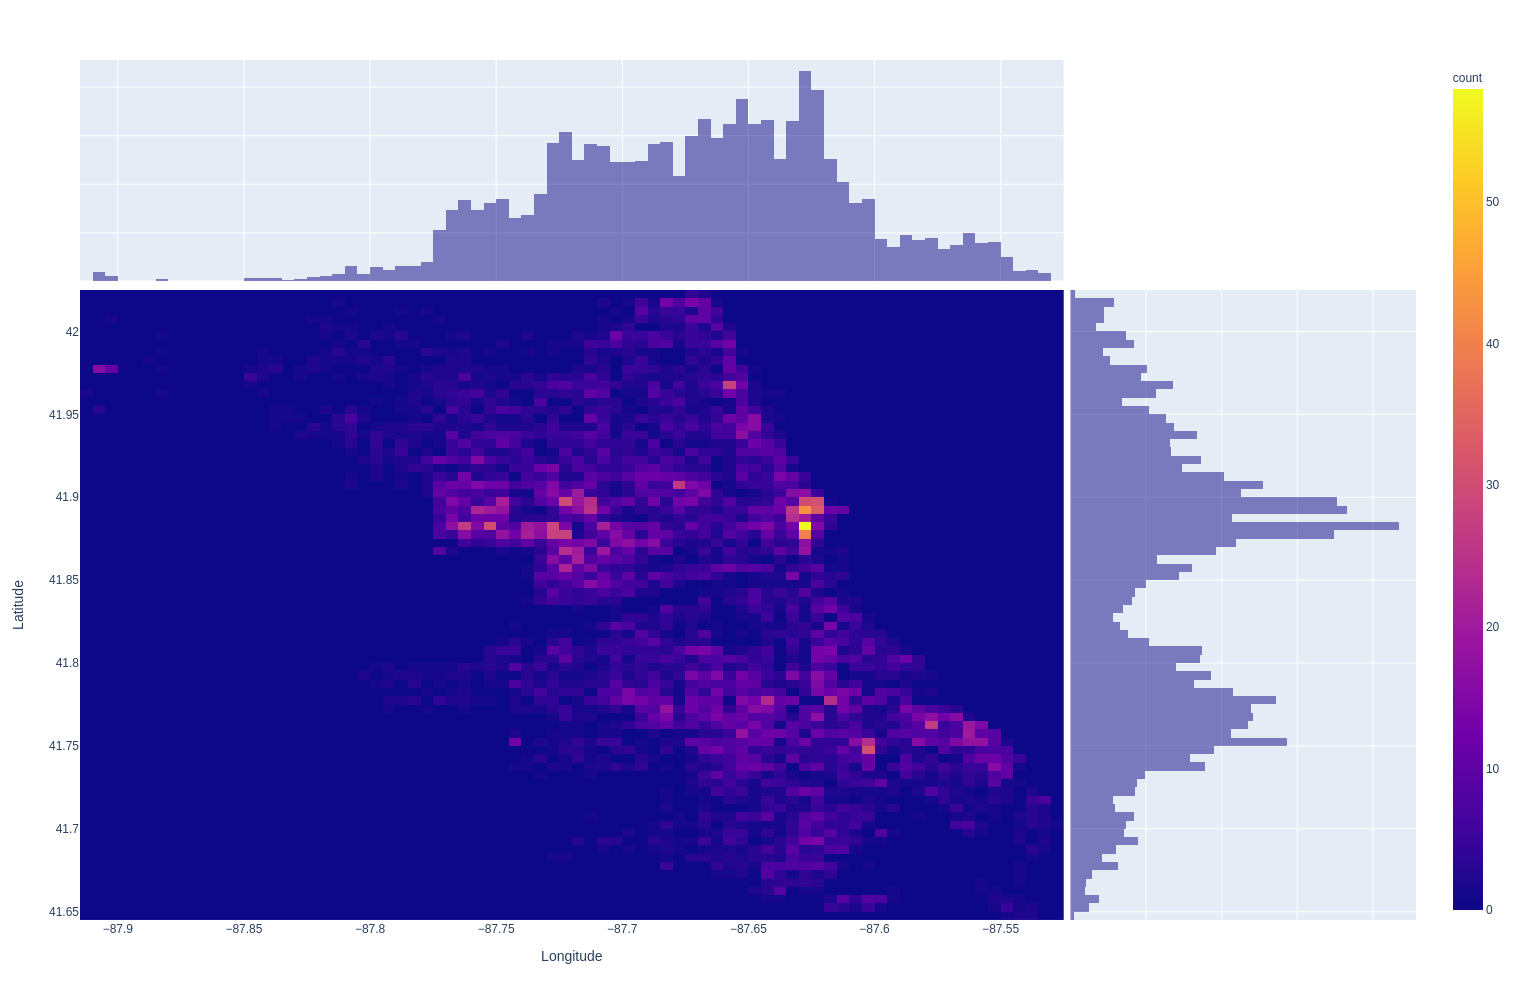

In [45]:
# display distribution of a sample of the data
fig_height=1000
fig = px.density_heatmap(
    data_frame=df.sample(10000),
    x="Longitude",
    y="Latitude", 
    marginal_x="histogram",
    marginal_y="histogram",
    height=fig_height,
    width=ratio_xy*fig_height,
    nbinsx=nx,
    nbinsy=ny,
)
fig.show()

`Reference for code to compare grids with previous generation techniques:`
```python
file_location = "data/processed/T24H-X425M-Y440M_2013-01-01_2017-01-01/"

generated_data = np.load(file_location + "generated_data.npz")
x_range = generated_data['x_range']
y_range = generated_data['y_range']
t_range = pd.read_pickle(file_location + "t_range.pkl")

crime_types_grids = generated_data['crime_types_grids'] 

xbins  = x_range - dlon/2
xbins = np.array([*xbins,xbins[-1]+dlon])

ybins  = y_range - dlat/2
ybins = np.array([*ybins,ybins[-1]+dlat])

import json

with open(file_location + "info.json", "r") as f:
    meta_info = json.load(f)
         
meta_info
```

In [46]:
counts, edges = np.histogramdd(
    sample=df[['t', 'c', 'Latitude', 'Longitude']].values,
    bins=(tbins, cbins, ybins, xbins),
) # (nt, nc, ny, nx))

tbins, cbins, ybins, xbins = edges

counts_sum  = counts.sum(1)
counts_mean = counts_sum.mean(0)

counts.shape

(1827, 8, 95, 83)

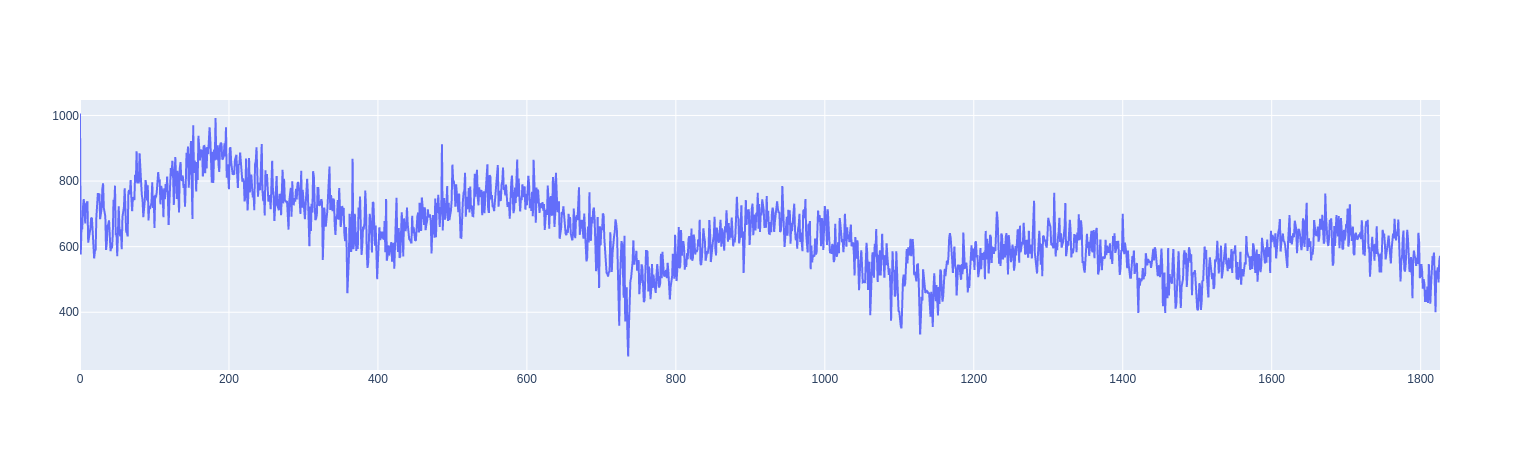

In [48]:
def new_scatter(y,name=None):
    return go.Scatter(y=y,x=np.arange(len(y)),name=name)

go.Figure([
    new_scatter(counts_sum.sum(1).sum(1),'new'),
])

In [49]:
# todo get better init values or save in state object
lon_filter = None
lat_filter = None
date_range_filter = None
selected_crime_types = None
current_date_label = None
time_index = 0

In [50]:
from utils.plots import hist2d_to_geo

In [51]:
blocks, values = hist2d_to_geo(counts_mean,xbins,ybins,filter_zero=True)

In [52]:
sub = df.sample(1000)

### Setup plots

In [53]:
heatmap = go.Choroplethmapbox(
    geojson=blocks,
    locations=values.id,
    z=values.value,
    colorscale="Viridis",
    zmin=values.value.min(),
    zmax=values.value.max(),
    marker_opacity=0.5,
    marker_line_width=0,
    name='heatmap',
    hoverinfo='text',
    hovertext=values[['y','x','value']],
)

scatter = go.Scattermapbox(
    lon=sub.Longitude,
    lat=sub.Latitude,
    opacity=.4,
    hoverinfo='skip',
    name='scatter',
)

fig = go.FigureWidget(data=[heatmap, scatter])

fig.update_layout(
    clickmode='event+select',
    mapbox_style=mapbox_styles["sat"],
    mapbox_accesstoken=mapbox_access_token,
    mapbox_zoom=10,
    mapbox_center = {"lat": np.mean(ybins), "lon": np.mean(xbins)},
    margin={"r":0,"t":30,"l":0,"b":10},
    height=500,
#     showlegend=True,
#     legend=dict(
#         yanchor="top",
#         y=0.99,
#         xanchor="left",
#         x=0.01,
#     ),
)

def heatmap_on_select(trace,points,selector):
    global lat_filter, lon_filter
    
    inds = points.point_inds
    selection = values.iloc[inds]
    _,_,f_x_min,f_y_min = selection.min()
    _,_,f_x_max,f_y_max = selection.max()

    lon_filter = xbins[[f_x_min,f_x_max]]
    lat_filter = ybins[[f_y_min,f_y_max]]
    
    
heatmap = fig.data[0]    
# heatmap.on_click(callback_fn)
heatmap.on_selection(heatmap_on_select)

fig

FigureWidget({
    'data': [{'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
               …

In [54]:
scattergl = go.Scattergl(
    x=sub.Longitude,
    y=sub.Latitude,
    opacity=.6,
    hoverinfo='skip',
    mode='markers',
    name='scattergl',
#     marker_symbol="x-thin", # "cross",
    marker_color='red',
#     hovertext="",
)

heatmapgl = go.Heatmap(
    z=counts_mean,
    x=xbins,
    y=ybins, 
    hoverinfo='skip',
    colorscale='viridis',
    opacity=1,
    name='heatmapgl',
)


fig_height = 600

fig2 = go.FigureWidget(
    data=[heatmapgl, scattergl],
    layout=dict(
        margin={"r":50,"t":30,"l":0,"b":0},
        height=fig_height,
#         width=fig_height*ratio_xy,
        yaxis=dict(scaleanchor="x", scaleratio=1/ratio_xy),
        clickmode='event+select',
    ),
)

scattergl = fig2.data[1]

In [55]:
import plotly.express as px


series = sub.groupby(by=['t'])['ID'].count().reset_index(name="Count") # too many missing values - use hist
fline = go.FigureWidget(px.line(data_frame=series, x="t",y='Count'))

In [56]:
counts, edges = np.histogram(sub.t,bins=tbins)

In [57]:
from sparse_discrete_table import SparseDiscreteTable, build_discrete_table

In [58]:
import matplotlib.pyplot as plt

In [59]:
from utils.plots import plot

In [60]:
def get_mi_score(counts, max_offset=30, norm=False):
    log_counts = np.round(np.log2(1 + counts))
    rv_names = ['rv0_c','rv1_c-k']
    mi_scores = []
    for k in range(1,max_offset):
        obs_arr = np.stack([log_counts[k:],log_counts[:-k]],axis=1)
        rv = build_discrete_table(
            obs_arr=obs_arr,
            rv_names=rv_names,
        )
        mi_score = rv.mutual_information(['rv0_c'],['rv1_c-k'], norm)
        mi_scores.append(mi_score)
    return mi_scores

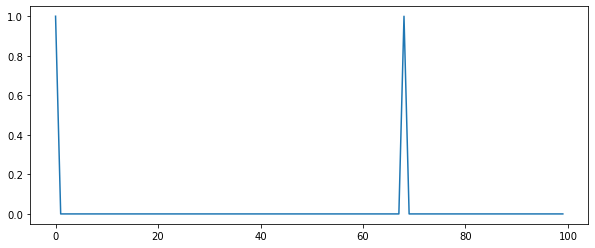

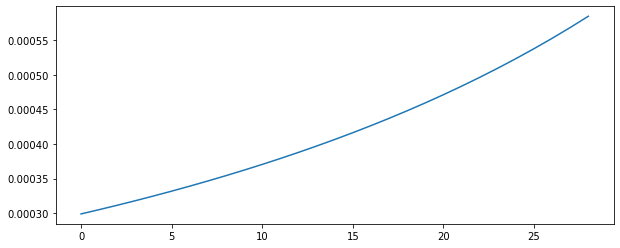

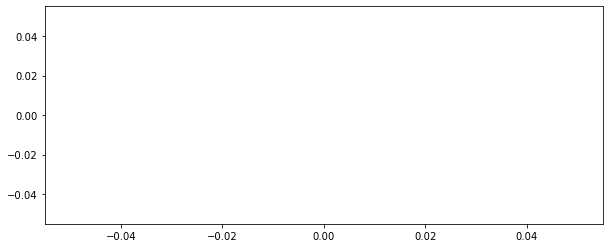

In [70]:
obs = gen_obs(k,mu,w,n)
mi = gen_mi(obs)
nmi_new = get_mi_score(np.array(obs), True)
mi_new = get_mi_score(np.array(obs), False)

plt.figure(figsize=(10,4))
plt.plot(obs)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(mi)
plt.plot(mi_new)
plt.plot(nmi_new)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(mi_new)
plt.show()

In [62]:
# global updater
def update_data():
    global df, sub, lon_filter, lat_filter, date_range_filter, time_index, tbins, nt
    
    # spatial filters
    if lon_filter is not None:
        f_lon_min, f_lon_max = lon_filter
        lon_mask = (df.Longitude >= f_lon_min) & (df.Longitude <= f_lon_max)
    
    if lat_filter is not None:
        f_lat_min, f_lat_max = lat_filter
        lat_mask = (df.Latitude >= f_lat_min) & (df.Latitude <= f_lat_max)
    
    
    # time filters
    f_date_min, f_date_max = date_range[[*date_range_filter]]
    date_range_mask = (df.Date >= f_date_min) & (df.Date <= f_date_max) 
    
    # crime type filters
    crime_types_mask = df['Primary Type'].isin(selected_crime_types)
    
    selected_mask = date_range_mask & crime_types_mask
    
    if lat_filter and lon_filter:
        selected_mask = selected_mask & lon_mask & lat_mask
    
    sub = df[selected_mask]
    
    nt = int(np.ceil(sub['t'].max()))
    tbins = np.arange(int(np.floor(sub['t'].min())),nt+2,1)
    
    counts, edges = np.histogram(sub.t,bins=tbins)
        # todo implement histo
#     counts, edges = np.histogramdd(
#         sample=sub[['t', 'c', 'Latitude', 'Longitude']].values,
#         bins=(tbins, cbins, ybins, xbins),
#     )
    
#     series = sub.groupby(by=['t'])['ID'].count().reset_index(name="Count") # dont use - too mayn missing values
    
    with fig2.batch_update():
        scattergl.x=sub.Longitude
        scattergl.y=sub.Latitude
        
        fline.data[0].x = date_range[edges[:-1]] # edges[:-1]   #series.t
        fline.data[0].y = counts   #series["Count"]

In [63]:
def scattergl_on_select(trace,points,selector):
    global lat_filter, lon_filter
    if trace.name == 'scattergl':                
        lon_filter = selector.xrange
        lat_filter = selector.yrange
        
        update_data()
        
    
scattergl.on_selection(scattergl_on_select)

### Setup widgets
TODO: split widgets into 2 types:
- Filter base data
- Select data (point in time and space)

In [64]:
# widget setup
from ipywidgets import Layout, widgets

# helper functions
def get_widget_index(change):
    if isinstance(change, dict) and change.get('name') == 'index':
        return change.get('new')
    return None

def get_widget_value(change):
    if isinstance(change, dict) and change.get('name') == 'value':
        return change.get('new')
    return None


# date selectors
date_range = pd.date_range(df.Date.min().ceil('1D'), df.Date.max().floor('1D'), freq='1D')

date_range_filter = (0,-1)

date_range_slider = widgets.SelectionRangeSlider(
    options=[d.strftime('%y/%m/%d') for d in date_range],
    index=(0, len(date_range)-1),
    description='Date Range:',
    disabled=False,
    orientation = 'horizontal',
    layout=Layout(width='95%'),
    continuous_update=False,
)

def set_date_range_filter(change):
    global date_range_filter
    
    index = get_widget_index(change)
    if index:
        date_range_filter = index
        update_data()

date_range_slider.observe(set_date_range_filter)


# date display label
current_date_label = widgets.Label(f'Date: {date_range[0]}')

# time index selector
time_index_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(date_range)-1,
    step=1,
    description='Time Index:',
    continuous_update=False,
    layout=Layout(width='80%'),
)

def time_index_change(change):
    global current_date_label, time_index
    time_index = get_widget_value(change)
    if time_index:
        current_date_label.value = f'Date: {date_range[time_index]}'
        
time_index_slider.observe(time_index_change)

play_button = widgets.Play(
    value=0,
    min=time_index_slider.min,
    max=time_index_slider.max,
    step=1,
    interval=500,
    description="Press play",
    disabled=False
)

widgets.jslink((play_button, 'value'), (time_index_slider, 'value'))

time_selectors = widgets.VBox([
    widgets.HBox([date_range_slider]),
    widgets.HBox([time_index_slider])    
])


# crime type selector
selected_crime_types = []

def set_selected_crime_types(button):
    global selected_crime_types
    if button.button_style == "":
        button.button_style = "success"
        selected_crime_types.append(button.description)
    else:
        button.button_style = ""
        selected_crime_types.remove(button.description)
    update_data()
    
def new_buttons(names,all_selected=False):
    global selected_crime_types
    buttons = []
    
    if all_selected:
        selected_crime_types = [*names]
        button_style = "success"
    else:
        selected_crime_types = []
        button_style = ""
        
    for name in names:
        button = widgets.Button(
            description=name,
            tooltip=name,
            disabled=False,
            button_style=button_style, # 'success', 'info', 'warning', 'danger' or ''
        )
        
        button.on_click(set_selected_crime_types)
        
        buttons.append(button)
    return buttons
    
buttons = new_buttons(names=crime_categories, all_selected=True)
crime_selectors = widgets.VBox([
    widgets.HBox(buttons[:3]),
    widgets.HBox(buttons[3:6]),
    widgets.HBox(buttons[6:]),
])


# widgets combinations and setup
row0 = widgets.HBox([play_button, crime_selectors])
row1 = time_selectors

controller = widgets.VBox([row0, row1,current_date_label])

In [65]:
date_range_filter = (0,-1)
update_data()
widgets.VBox([fline, controller, fig2])

    'data': [{'hovertemplate': 't=%{x}<br>Count=%{y}<extra></extra>',
          …

---
### Animated Crime Over Time

In [164]:
def new_ffloor(delta):
    def res(value): 
        return ffloor(value, delta)
    return res


sub = df[['t', 'Longitude', 'Latitude','c', 'Primary Type', 'Date']].sample(10_000).copy()
sub['date_str'] = sub.Date.dt.floor('1D').dt.strftime('%c')
sub['count'] = np.ones_like(sub.t)
ff = new_ffloor(0.01)
sub[['Longitude', 'Latitude']] = sub[['Longitude', 'Latitude']].apply(ff)

gb = sub.groupby(by=['Longitude', 'Latitude','t','c'])
points = gb.first()
points['count'] = gb.count()['count']
# points['count'] = points['count'].apply(lambda x: np.log2(1+x))
points['count'] = points['count']/points['count'].min()
points = points.reset_index()
points = points.sort_values(['t','c'])

points = points[points.t < 4*5]
points

,Longitude,Latitude,t,c,Primary Type,Date,date_str,count
1186,-87.75,41.90,0,0,THEFT,2012-01-01 17:00:00,Sun Jan 1 00:00:00 2012,1.0
4656,-87.68,41.96,0,0,THEFT,2012-01-01 17:22:00,Sun Jan 1 00:00:00 2012,1.0
5371,-87.67,41.99,0,0,THEFT,2012-01-01 22:00:00,Sun Jan 1 00:00:00 2012,1.0
5855,-87.66,41.90,0,0,THEFT,2012-01-01 13:30:00,Sun Jan 1 00:00:00 2012,1.0
6449,-87.65,41.79,0,0,THEFT,2012-01-01 09:00:00,Sun Jan 1 00:00:00 2012,1.0
...,...,...,...,...,...,...,...,...
810,-87.76,41.89,18,1,BATTERY,2012-01-19 04:25:00,Thu Jan 19 00:00:00 2012,1.0
8485,-87.62,41.80,19,1,BATTERY,2012-01-20 15:25:00,Fri Jan 20 00:00:00 2012,1.0
4002,-87.69,41.86,19,3,NARCOTICS,2012-01-20 20:40:00,Fri Jan 20 00:00:00 2012,1.0
4351,-87.68,41.77,19,5,BURGLARY,2012-01-20 08:00:00,Fri Jan 20 00:00:00 2012,1.0


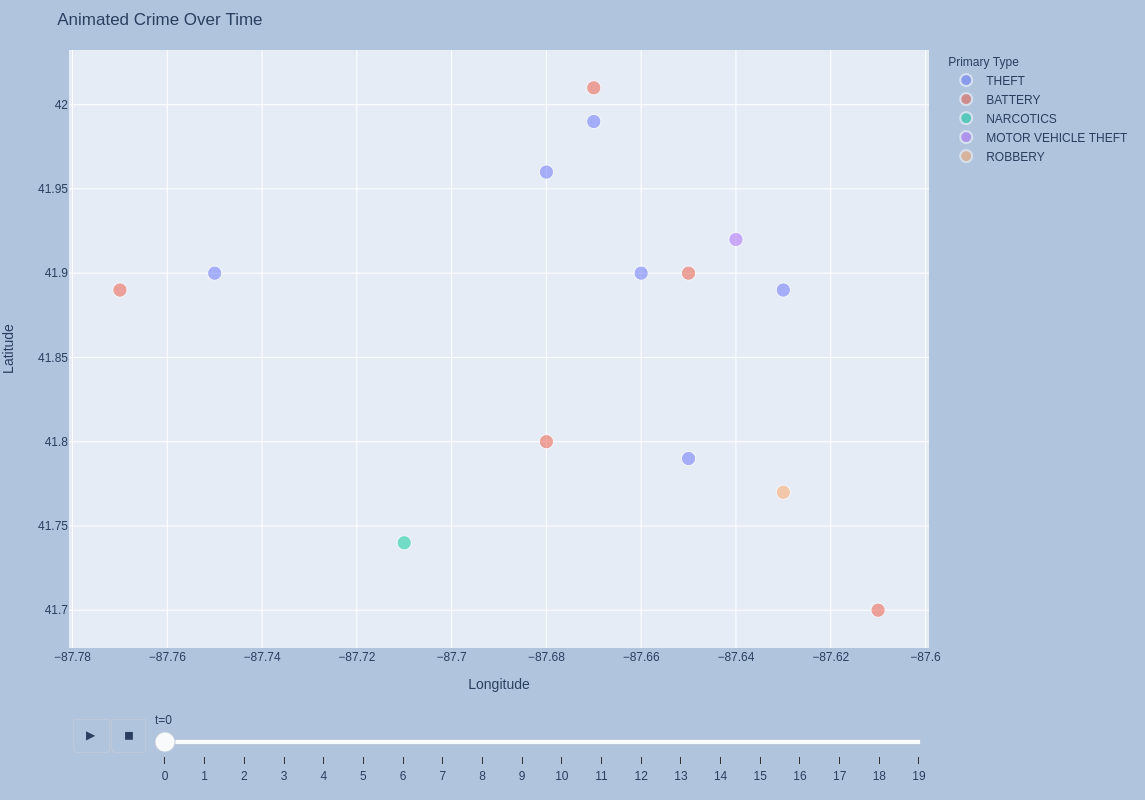

In [168]:
import plotly.express as px

points['size'] = 10*points['count']

fig = px.scatter(
    data_frame=points, 
    x="Longitude", 
    y="Latitude", 
    title="Animated Crime Over Time",
#     facet_col="Primary Type",
#     facet_col_wrap=3,
    width=800, 
    height=800,
    opacity=.5,
    size="size",
    size_max=points['size'].max(),
    color='Primary Type',
#     marginal_x='violin',
    animation_frame="t",
#     animation_group="t",
#     color="count",
)

fig.update_layout(
    margin=dict(l=20, r=50, t=50, b=20),
    paper_bgcolor="LightSteelBlue",
#     transition ={'duration': 1},
#     frame={'duration': 100},
)

fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 500
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 0

fig

---